In [107]:
import json
import math
import pytz
from datetime import datetime,timedelta,timezone
from dateutil.tz import tzutc
from dateutil.relativedelta import relativedelta
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import csv
from scipy.interpolate import interp1d
from scipy.stats import pearsonr, mode
from scipy.signal import savgol_filter
import xgboost as xgb
import sklearn
from sklearn.metrics import mean_squared_error,plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
from scipy.interpolate import UnivariateSpline

addDataPrefix='/Users/sorush/My Drive/Documents/Educational/TAMU/Research/Trial/Data/11-5-21-11-15-21'
if not os.path.exists(addDataPrefix):
    addDataPrefix='/home/grads/s/sorush.omidvar/CGMDataset/Trial/Data/11-5-21-11-15-21'
addUserInput=os.path.join(addDataPrefix,'User inputted')
addHKCM=os.path.join(addDataPrefix,'hk+cm')
addCGM=os.path.join(addDataPrefix,'CGM')
addE4=os.path.join(addDataPrefix,'E4')

exempts=['p2']

pd.options.mode.chained_assignment = None  # default='warn'
plt.style.use({'figure.facecolor':'white'})

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 50)

In [224]:
# if os.path.exists(os.path.join(addDataPrefix,'All_meals.pkl')):
#     os.remove(os.path.join(addDataPrefix,'All_meals.pkl'))
os.chdir(addUserInput)
if not os.path.exists(os.path.join(addDataPrefix,'All_meals.pkl')):    
    df=[]
    for root, dirs, files in os.walk(addUserInput):
        for file in files:
            if '.csv' in file.lower():
                if 'meals' in file.lower():
                    participantName=file[:file.find('Meals')]
                    if participantName in exempts:
                        print("Exemption...",file)
                        continue
                    print("Reading ...",file)
                    dfTemp = pd.read_csv(file)
                    dfTemp.insert(0,'Participant',participantName)
                    dfTemp.rename(columns={'startTime':'StartTime'}, inplace=True)
                    dfTemp['StartTime']=pd.to_datetime(dfTemp['StartTime'])
                    dfTemp['FinishTime']=pd.to_datetime(dfTemp['FinishTime'])

                    dfTemp['StartTime']-=pd.DateOffset(hours=5)#fixing the time zone issue
                    dfTemp['FinishTime']-=pd.DateOffset(hours=5)#fixing the time zone issue            
                    dfTemp.sort_values(["Participant",'StartTime'],ascending = (True, True),inplace=True)
                    if len(dfTemp.columns)!=10:
                        print("MAYDAY. Error in reading csv")
                        break
                    if len(df)!=0:
                        frames=[dfTemp,df]
                        df=pd.concat(frames)
                    else:
                        df=dfTemp
    print("reading is done")
    dfMeal=df    
    dfMeal.to_pickle(os.path.join(addDataPrefix,'All_meals.pkl')) 
else:
    dfMeal=pd.read_pickle(os.path.join(addDataPrefix,'All_meals.pkl'))


if os.path.exists(os.path.join(addDataPrefix,'All_cgm.pkl')):
    os.remove(os.path.join(addDataPrefix,'All_cgm.pkl'))
if not os.path.exists(os.path.join(addDataPrefix,'All_cgm.pkl')):
    os.chdir(addCGM)
    df=[]
    for root, dirs, files in os.walk(addCGM):
        for file in files:
            if '.csv' in file.lower():
                if 'processed' in file.lower():
                    participantName=file[:file.find('Processed')]
                    if participantName in exempts:
                        print("Exemption...",file)
                        continue
                    print("Reading ...",file)
                    dfTemp = pd.read_csv(file)
                    dfTemp['Time']=pd.to_datetime(dfTemp['Time'])
                    dfTemp.sort_values(["Time"],ascending = (True),inplace=True)
                    if len(dfTemp.columns)!=3:
                        print("MAYDAY. Error in reading csv")
                        break
                    index=dfTemp['Time']
                    seriesParticipant = pd.Series(dfTemp['Dexcom'].to_list(), index=index)
                    seriesParticipant=seriesParticipant.resample('1T').asfreq()
                    seriesParticipant.interpolate(method='polynomial',order=3,inplace=True)
                    tempTime=seriesParticipant.index
                    tempVal=seriesParticipant.values
                    dfTemp=pd.DataFrame(zip(tempTime,tempVal),columns=['Time','Dexcom'])
                    dfTemp.insert(0,'Participant',participantName)
                    if len(df)!=0:
                        frames=[dfTemp,df]
                        df=pd.concat(frames)
                    else:
                        df=dfTemp
    print("reading is done")
    dfCGM=df
    dfCGM.to_pickle(os.path.join(addDataPrefix,'All_cgm.pkl')) 
else:
    dfCGM=pd.read_pickle(os.path.join(addDataPrefix,'All_cgm.pkl'))


    
# # if os.path.exists(os.path.join(addDataPrefix,'All_cm.pkl')):
# #     os.remove(os.path.join(addDataPrefix,'All_cm.pkl'))
# os.chdir(addHKCM)
# if not os.path.exists(os.path.join(addDataPrefix,'All_cm.pkl')):
#     df=[]
#     for root, dirs, files in os.walk(addHKCM):
#         for file in files:
#             if '.csv' in file.lower():
#                 if 'cm' in file.lower() and 'modified' in file.lower():
#                     participantName=file[:file.find('_cm')]
#                     if participantName in exempts:
#                         print("Exemption...",file)
#                         continue
#                     print("Reading ...",file)
#                     dfTemp=pd.read_csv(file)
#                     print("File is read")
#                     dfTemp['Time']=pd.to_datetime(dfTemp['Time'])
#                     dfTemp.insert(0,'Participant',participantName)
#                     dfTemp.insert(len(dfTemp.columns),'|Ax|+|Ay|+|Az|',dfTemp['Ax'].abs()+dfTemp['Ay'].abs()+dfTemp['Az'].abs()+0.001)#this is to avoid 0 later on for feature calculation
#                     dfTemp.insert(len(dfTemp.columns),'|Yaw|+|Roll|+|Pitch|',dfTemp['Yaw'].abs()+dfTemp['Roll'].abs()+dfTemp['Pitch'].abs())
#                     dfTemp.insert(len(dfTemp.columns),'RotationalToLinear',dfTemp['|Yaw|+|Roll|+|Pitch|']/dfTemp['|Ax|+|Ay|+|Az|'])
#                     print("modified")
#                     dfTemp.sort_values(['Time'],ascending = (True),inplace=True)
#                     print("sorted")
#                     if len(dfTemp.columns)!=14:
#                         print("MAYDAY. Error in reading csv")
#                         print(dfTemp.columns)
#                         break
#                     if len(df)!=0:
#                         frames=[dfTemp,df]
#                         df=pd.concat(frames)
#                     else:
#                         df=dfTemp
#     dfCM=df
#     print("Processing is done")
#     dfCM.to_pickle(os.path.join(addDataPrefix,'All_cm.pkl')) 
# else:
#     dfCM = pd.read_pickle(os.path.join(addDataPrefix,'All_cm.pkl'))


Reading ... p3Processed.csv
Reading ... p4Processed.csv
Exemption... p2Processed.csv
Reading ... p1Processed.csv
reading is done
['p3', 'p1', 'p4']


KeyError: 'Abbot'

In [61]:
def featureExtractorMotion(df):
    f1=df['RotationalToLinear'].mean()
    f2=df['|Ax|+|Ay|+|Az|'].mean()
    f5=df['|Yaw|+|Roll|+|Pitch|'].mean()
    return [f1,f2,f5]

def featureExtractorCGM(df):
    mean=df['Abbot'].mean()
    std=df['Abbot'].std()
    max=df['Abbot'].max()
    min=df['Abbot'].min()
    return mean, std, min,max

MINIMUM_POINT_CM=10
WINDOW_LENGTH=timedelta(minutes=2)
MEAL_MAX_TIME=timedelta(minutes=30)
MEAL_PORTION_RELAXATION=timedelta(seconds=10)
START_OF_TRIAL = datetime.strptime('11 06 2021-02:00:00', '%m %d %Y-%H:%M:%S')#to handle the daylight saving issue in apple watches
END_OF_TRIAL = datetime.strptime('11 15 2021-00:00:00', '%m %d %Y-%H:%M:%S')


dfMeal=dfMeal[dfMeal['StartTime']>=START_OF_TRIAL]
dfMeal=dfMeal[dfMeal['FinishTime']<END_OF_TRIAL]
print("Meal database is limited to the trial period")

dfCM=dfCM[dfCM['Time']>=START_OF_TRIAL]
dfCM=dfCM[dfCM['Time']<END_OF_TRIAL]
print("CM databse is limited to the trial period")

participants=dfCM['Participant'].to_list()
participants=list(set(participants))
participantDataList=[]
skippedWindows=0

if os.path.exists(os.path.join(addDataPrefix,'Features.npy')):
    os.remove(os.path.join(addDataPrefix,'Features.npy'))
if not os.path.exists(os.path.join(addDataPrefix,'Features.npy')):
    for participant in participants:
        windowStart=START_OF_TRIAL
        windowEnd=windowStart+WINDOW_LENGTH        
        print("Participant ",participant," is started")
        dfParticipantCM=dfCM[dfCM['Participant']==participant]
        dfParticipantMeal=dfMeal[dfMeal['Participant']==participant]
        print("CM size for participant",len(dfParticipantCM))
        for counter in tqdm(range(0,int((END_OF_TRIAL-START_OF_TRIAL).total_seconds()/WINDOW_LENGTH.total_seconds()),1)):
            dfTempCM=dfParticipantCM[(dfParticipantCM['Time']>=windowStart) & (dfParticipantCM['Time']<=windowEnd)]
            dfTempMeal=dfParticipantMeal[(dfParticipantMeal['StartTime']-MEAL_PORTION_RELAXATION<=windowStart) & (dfParticipantMeal['FinishTime']+MEAL_PORTION_RELAXATION>=windowEnd)]
            dfTempMeal=dfTempMeal[dfTempMeal['StartTime']+MEAL_MAX_TIME>=dfTempMeal['FinishTime']]
            if(len(dfTempCM)<MINIMUM_POINT_CM):
                windowStart+=WINDOW_LENGTH
                windowEnd+=WINDOW_LENGTH
                skippedWindows+=1
                continue
            tempList=featureExtractorMotion(dfTempCM)
            if(len(dfTempMeal)!=0):
                tempList.append(1)
            else:
                tempList.append(0)
            tempList.append(participant[1:])           
            if(len(tempList)!=5):
                print("MAYDAY. The length is not right")
                print(windowStart,windowEnd)
                break
            participantDataList.append(tempList)
            windowStart+=WINDOW_LENGTH
            windowEnd+=WINDOW_LENGTH
    participantDataArray=np.asarray(participantDataList)
    np.save(os.path.join(addDataPrefix,'Features'),participantDataArray)
else:
    participantDataArray = np.load(os.path.join(addDataPrefix,'Features.npy'))

print("Total number of skipped windows:",skippedWindows, " the shape of the data:",participantDataArray.shape)

Meal database is limited to the trial period
CM databse is limited to the trial period
Participant  p1  is started
CM size for participant 7643165


100%|██████████| 6420/6420 [02:28<00:00, 43.34it/s]


Participant  p3  is started
CM size for participant 7567184


100%|██████████| 6420/6420 [02:26<00:00, 43.72it/s]


Participant  p4  is started
CM size for participant 7191513


100%|██████████| 6420/6420 [02:17<00:00, 46.66it/s]


Total number of skipped windows: 649  the shape of the data: (18611, 5)


(18936.50358796296, 18936.666666666668)

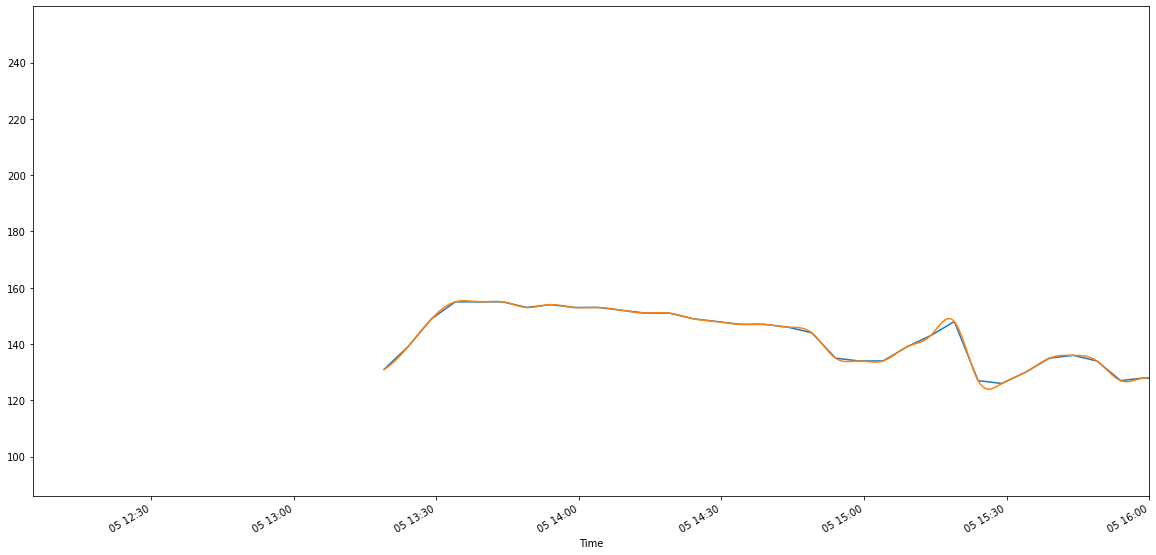

In [62]:
def STMI_XGBoost(xTrain,xVal,xTest,yTrain,yVal,yTest):
    f1ScoreBest=0
    for maxDepth in tqdm(np.arange(1,5,1)):
        for estimator in np.arange(50,200,50):
            for threshold in np.arange(0.2,0.9,0.2):
                clf = xgb.XGBClassifier(scale_pos_weight = 50, n_jobs=18,n_estimators=estimator,max_depth=maxDepth, objective = "binary:logistic", eval_metric = "error")
                clf.fit(xTrain,yTrain)
                predictionsVal = clf.predict(xVal)
                # predictionsVal = clf.predict_proba(xVal)
                # predictionsVal=predictionsVal[:,1]
                # predictionsVal[predictionsVal>=threshold]=1
                # predictionsVal[predictionsVal<threshold]=0

                confMatrix=sklearn.metrics.confusion_matrix(yVal,predictionsVal)
                accuracy=sklearn.metrics.accuracy_score(yVal,predictionsVal)
                recall=sklearn.metrics.recall_score(yVal,predictionsVal)
                precision=sklearn.metrics.precision_score(yVal,predictionsVal)
                f1Score=sklearn.metrics.f1_score(yVal,predictionsVal)

                if f1Score>f1ScoreBest:
                    confMatrixBest=confMatrix
                    accuracyBest=accuracy
                    modelBest=clf
                    recallBest=recall
                    precisionBest=precision
                    thresholdBest=threshold
                    f1ScoreBest=f1Score
    print("***********Val:")
    print(confMatrixBest)
    print("Accuracy:",np.round(100*accuracyBest,0),"Recall:",np.round(100*recallBest,0),"Precision:",np.round(100*precisionBest,0))
    print("***********Test:")
    predictionsTest=modelBest.predict(xTest)
    # predictionsTest=modelBest.predict_proba(xTest)
    # predictionsTest=predictionsTest[:,1]
    # predictionsTest[predictionsTest>=thresholdBest]=1
    # predictionsTest[predictionsTest<thresholdBest]=0    
    
    confMatrix=sklearn.metrics.confusion_matrix(yTest,predictionsTest)
    accuracy=sklearn.metrics.accuracy_score(yTest,predictionsTest)
    recall=sklearn.metrics.recall_score(yTest,predictionsTest)
    precision=sklearn.metrics.precision_score(yTest,predictionsTest)
    
    print(confMatrix)
    print("Accuracy:",np.round(100*accuracy,0),"Recall:",np.round(100*recall,0),"Precision:",np.round(100*precision,0))
    plot_confusion_matrix(modelBest, xTest, yTest,cmap='bone') 

def dataBalancer(xTrain,xVal,yTrain,yVal):
    oversample = SMOTE()
    xVal, yVal = oversample.fit_resample(xVal, yVal)
    xTrain, yTrain = oversample.fit_resample(xTrain, yTrain)

    return xTrain,xVal,yTrain,yVal

def testTrainSplitFunc(data,randomSeed,normalFlag):
    data=data.astype(float)
    participants=data[:,data.shape[1]-1]
    participants=list(set(participants))
    for participant in participants:
        print("Participant:",participant)
        indxList=[]
        for counter in range(len(data)):
            if(data[counter,data.shape[1]-1]==participant):
                indxList.append(counter)
        dataTemp=data[indxList,:]
        dataX=dataTemp[:,0:dataTemp.shape[1]-2]
        dataY=dataTemp[:,dataTemp.shape[1]-2]

        random.seed(randomSeed)
        np.random.shuffle(data)
        if(normalFlag):
            dataX=dataX-dataX.mean(axis=0)
            dataX/=dataX.std(axis=0)
        
        stratidiedSampling = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=randomSeed)
        for trainIndex, testIndex in stratidiedSampling.split(dataX, dataY):
            xTrain,xTest=dataX[trainIndex],dataX[testIndex]
            yTrain,yTest=dataY[trainIndex],dataY[testIndex]

        stratidiedSampling = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=randomSeed)
        for trainIndex, valIndex in stratidiedSampling.split(xTrain, yTrain):
            xTrain,xVal=dataX[trainIndex],dataX[valIndex]
            yTrain,yVal=dataY[trainIndex],dataY[valIndex]

        # xTrain,xVal,yTrain,yVal=dataBalancer(xTrain,xVal,yTrain,yVal)
        STMI_XGBoost(xTrain,xVal,xTest,yTrain,yVal,yTest)

randomSeed=random.randrange(50)
print("Without NORMALIZATION")
NORMALIZED_FLAG=False
testTrainSplitFunc(participantDataArray,randomSeed,NORMALIZED_FLAG)


print("With NORMALIZATION")
NORMALIZED_FLAG=True
testTrainSplitFunc(participantDataArray,randomSeed,NORMALIZED_FLAG)

Without NORMALIZATION
Participant: 1.0


 83%|████████▎ | 24/29 [21:42<04:31, 54.29s/it]


KeyboardInterrupt: 